# Conclusion
Final chosen method for HE => CLAHE

Final chosen method for sharpening:
- if we need speed => choose USM (parameter free)
- if we need accuracy => choose homomorphic filter

In [13]:
# -*- encoding: utf-8 -*-
import sys
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from typing import Tuple

# constant
TRACK_MAX_VAL = 100
# paths
PATH_IMAGE = 'D:\\My_Data\\me_Docs\\Masterarbeit\\master_border_extraction\\images\\test1.png'
PATH_OUTPUT = 'D:\\My_Data\\me_Docs\\Masterarbeit\\master_border_extraction\\data\\output\\'

# env: windows
img_bgr_origin = cv2.imread(PATH_IMAGE, cv2.IMREAD_COLOR)  # color image
img_gray_origin = cv2.imread(PATH_IMAGE, cv2.IMREAD_GRAYSCALE) # gray image
img_rgb = cv2.cvtColor(img_bgr_origin, cv2.COLOR_BGR2RGB)

In [10]:
def set_odd_val(num):
    if num % 2 == 0:
        num += 1
    return num

def set_two_decimal(num):
    return float(num)/100

In [11]:
# meshgrid: N-D => extend to 1-D => combined to tuple  
def combine_grid_params(*param_lists) -> Tuple[list[tuple], int]:
    num_params = len(param_lists)

    param_grids = np.meshgrid(*param_lists, indexing='ij')
    param_flats = map(np.ndarray.flatten, param_grids)
    param_combine = list(zip(*param_flats))
    return param_combine, num_params

# example:
x = [1, 2, 3]
y = [4, 5, 6, 7]
res, cnt = combine_grid_params(x, y)
print(res, cnt)

[(1, 4), (1, 5), (1, 6), (1, 7), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7)] 2


## Histogramm Enhancement
Decision: Contrast Limited AHE (CLAHE)
- clipLimit
- tileGridSize

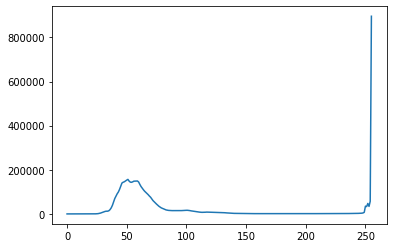

In [23]:
### histogramm of origianal image
hist_gray = cv2.calcHist([img_gray_origin],[0],None,[256],[0,256])   # shape is (256, 1)
plt.plot(hist_gray)

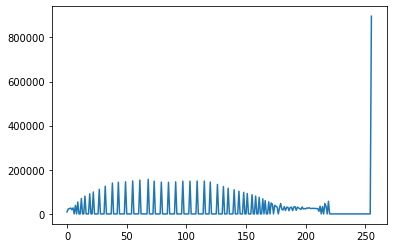

In [20]:
### Extra: HE
gray_equal = cv2.equalizeHist(img_gray_origin) 
hist_gray_equal = cv2.calcHist([gray_equal],[0],None,[256],[0,256])   # shape is (256, 1)

cv2.imwrite(PATH_OUTPUT+'preprocess_histogramm\\HE.png', gray_equal)
plt.plot(hist_gray_equal)

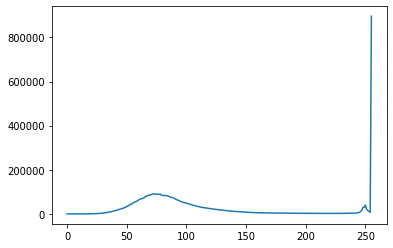

In [22]:
### CLAHE
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
### params gridsearch
clipLimit = np.linspace(1.0, 5.0, 6)
size_width = np.arange(3, 100, 20, dtype=np.uint8)
size_height = np.arange(3, 200, 40, dtype=np.uint8)

params, cnt = combine_grid_params(clipLimit, size_width, size_height)
# check params number:
if cnt != 3:
    raise ValueError

### output
for param in params:
    clahe = cv2.createCLAHE(clipLimit=param[0], tileGridSize=(param[1], param[2]))
    gray_clahe = clahe.apply(img_gray_origin)
    cv2.imwrite(PATH_OUTPUT+f'preprocess_histogramm\\clipLimit={param[0]}, tileGridSize={param[1], param[2]}.png', gray_clahe)

hist_gray_clahe = cv2.calcHist([gray_clahe],[0],None,[256],[0,256])   # shape is (256, 1)
plt.plot(hist_gray_clahe)

## Sharpening
Decision:

1) UMS => fast (params free)

True

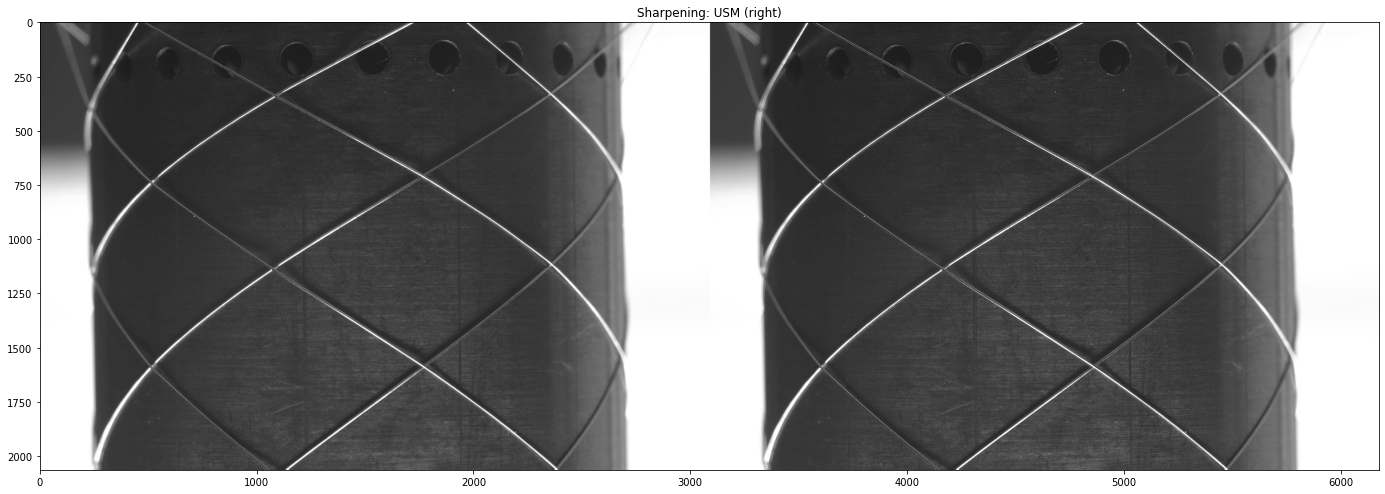

In [27]:
### Extra: UMS
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
gray_USM = cv2.filter2D(src=img_gray_origin, ddepth=-1, kernel=kernel)
sharp_USM = np.hstack((img_gray_origin, gray_USM))
plt.figure(figsize=(24, 13.5)), plt.title('Sharpening: USM (right)'), plt.imshow(sharp_USM, cmap='gray')  

cv2.imwrite(PATH_OUTPUT+f'preprocess_sharpen\\UMS.png', gray_USM)


2) homomorphoc filter => good result
- d0
- gamma_h
- gamma_l
- c
$$H(u, v)=(\gamma_H - \gamma_L)(1-e^{-c(D^2(u, v)/d_0^2)})+\gamma_L$$

In [28]:
from _homomorphicFilter import homomorphic_filter as homo_filter
### def homomorphic_filter(src, d0=10, gamma_h=2.5, gamma_l=0.5, c=1)
### params gridsearch
d0 = np.arange(10, 400, 100, dtype=np.uint16)
gamma_h = np.linspace(1.2, 3.0, 4)
gamma_l = np.linspace(0.1, 1.0, 4)
c = np.linspace(0.5, 2.0, 3)

params, cnt = combine_grid_params(d0, gamma_h, gamma_l, c)
# check params number:
if cnt != 4:
    raise ValueError

### output
for param in params:
    img_homo_filtered = homo_filter(img_gray_origin, d0=param[0], gamma_h=param[1], gamma_l=param[2], c=param[3])

    cv2.imwrite(PATH_OUTPUT+f'preprocess_sharpen\\d0={param[0]}, gamma_h={param[1]}, gamma_l={param[2]}, c={param[3]}.png', img_homo_filtered)


# sharp_homor = np.hstack((img_gray_origin, img_homo_filtered))
# plt.figure(figsize=(24, 13.5)), plt.title('Sharpening: Homomorphic Filter (right)'), plt.imshow(sharp_homor, cmap='gray')  

In [34]:
import time
start = time.time()
for i in range(10000):
    i += 100
end = time.time()
print(end-start)

0.0030040740966796875
